In [ ]:
import torch
import numpy as np

use_gpu = torch.cuda.is_available()
use_gpu

True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train/simpsons_dataset

abraham_grampa_simpson	  groundskeeper_willie	ned_flanders
agnes_skinner		  homer_simpson		nelson_muntz
apu_nahasapeemapetilon	  kent_brockman		otto_mann
barney_gumble		  krusty_the_clown	patty_bouvier
bart_simpson		  lenny_leonard		principal_skinner
carl_carlson		  lionel_hutz		professor_john_frink
charles_montgomery_burns  lisa_simpson		rainier_wolfcastle
chief_wiggum		  maggie_simpson	ralph_wiggum
cletus_spuckler		  marge_simpson		selma_bouvier
comic_book_guy		  martin_prince		sideshow_bob
disco_stu		  mayor_quimby		sideshow_mel
edna_krabappel		  milhouse_van_houten	snake_jailbird
fat_tony		  miss_hoover		troy_mcclure
gil			  moe_szyslak		waylon_smithers


In [ ]:
import pickle
import numpy as np
from skimage import io

#from tqdm import tqdm, tqdm_notebook
from tqdm.autonotebook import tqdm, trange
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split

from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# загрузка изображений с классами по папкам
# batch_size = 64
data_transforms = {
    'min_classes': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation((-30,30)),
        transforms.RandomGrayscale(p=0.4),
        transforms.RandomVerticalFlip(p=0.5)        
    ]),
    'train': transforms.Compose([
        transforms.Resize([299, 299]),
        transforms.RandomResizedCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([299, 299]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}




In [ ]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
  def __init__(self, datadir, min_class_transform, transform=None):
    tmp_dataset = datasets.ImageFolder(datadir)
    self.img_list = tmp_dataset.imgs
    self.min_class_transform = min_class_transform
    self.transform = transform
    self.class_names = tmp_dataset.classes
    self.n_classes = len(self.class_names)
    self.mean_percent_per_class = len(self.img_list)/self.n_classes/len(self.img_list)
    self.persent_per_class = [len([cl for _, cl in self.img_list if cl == c])/len(self.img_list) for c in range(self.n_classes)]
    self.weight_per_class = (1/np.array(self.persent_per_class)).tolist()

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, index):
      image = Image.open(self.img_list[index][0])
      if self.persent_per_class[self.img_list[index][1]] < self.mean_percent_per_class/10:
        image = self.min_class_transform(image)
      if self.transform:
        image = self.transform(image)
      return (image, self.img_list[index][1])


In [ ]:
data_dir = 'train/simpsons_dataset'
full_train_dataset = MyDataset(data_dir, data_transforms['min_classes'], data_transforms['train'])
# специальный класс для загрузки данных в виде батчей
#trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
#                                              shuffle=True, num_workers=2)
dataset_size = len(full_train_dataset)
class_names = full_train_dataset.class_names
n_classes = len(np.unique(full_train_dataset.class_names))
print(f'{dataset_size}, classes = {n_classes}')

20933, classes = 42


In [ ]:
# classes_count = {c: len([cl for _, cl in full_train_dataset.img_list if cl == c]) for c in range(n_classes)}
# counters = sorted(list(classes_count.values()))
# classes_count

In [ ]:
## функция создает массив весов по каждому объекту в зависимости от количества объектов этого класса
## чем меньше экземпляров класса, тем больше вес объекта
def make_weights(fullset, trainset, nclasses):                        
    # count = [0] * nclasses                                                      
    # for item in fullset.imgs:                                                         
    #     count[item[1]] += 1                                                     
    # weight_per_class = [0.] * nclasses                                      
    # N = float(sum(count))                                                   
    # for i in range(nclasses):                                                   
    #     weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(trainset.indices)                                              
    for idx, val in enumerate(trainset.indices):                                          
        weight[idx] = fullset.weight_per_class[fullset.img_list[val][1]]                                  
    return weight            

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

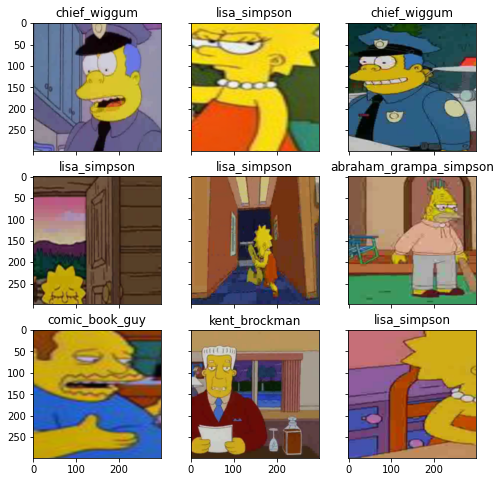

In [ ]:
# выведем
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,20933))
    im_val, label = full_train_dataset[random_characters]
    imshow(im_val.data.cpu(), \
          title=class_names[label],plt_ax=fig_x)

In [ ]:
# разбиение на тренировочный и валидационный
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
dataset_sizes = {'train': train_size, 'val': val_size}

In [ ]:
batch_size = 64
weights = make_weights(full_train_dataset, train_dataset, n_classes)
weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

In [ ]:
i_model = models.inception_v3(pretrained=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:47: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


In [ ]:
## замораживаем начальные слои и размораживаем несколько последних
## меняем последние слои (классификационные) на нужные нам количество классов
from torch import nn
# for param in i_model.parameters():
#    param.requires_grad = False
# for layer in i_model.Mixed_6a.parameters():
#   layer.requires_grad = True
# for layer in i_model.Mixed_6b.parameters():
#   layer.requires_grad = True
# for layer in i_model.Mixed_6c.parameters():
#   layer.requires_grad = True
# for layer in i_model.Mixed_7a.parameters():
#   layer.requires_grad = True
# for layer in i_model.Mixed_7b.parameters():
#   layer.requires_grad = True
# for layer in i_model.Mixed_7c.parameters():
#   layer.requires_grad = True
i_model.fc = nn.Linear(in_features=2048, out_features=n_classes, bias=True)
i_model.AuxLogits.fc = nn.Linear(in_features=768, out_features=n_classes, bias=True)

In [ ]:
import time
# функция тренировки модели
def train_model_inception(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    # Списки ошибок
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                # scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                #print(f'model training = {model.training}, phase = {phase}')
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "val":
                    with torch.no_grad():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                else:
                    outputs, aux_outputs = model(inputs)
                    #print(model.training, model.aux_logits)
                    #print(outputs.shape, aux_outputs.shape)
                    #break
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4 * loss2
                preds = torch.argmax(outputs, -1)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
DEVICE = torch.device("cuda")
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(i_model.parameters(), lr=1e-3)

# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
i_model = i_model.to(DEVICE)

In [ ]:
_, losses = train_model_inception(i_model, loss_fn, optimizer, num_epochs=32)

In [ ]:
import torch
torch.save(i_model, "gdrive/MyDrive/new_insection2.pt")

In [ ]:
!ls -l "gdrive/MyDrive/"

total 3098801
-rw------- 1 root root        143 Mar 19  2019 '168603511049695596.1.2.Инфо #@ ID@# .rtf.gdoc'
-rw------- 1 root root  333760512 Jan 21  2015  2nd-ready-eng.mpg
-rw------- 1 root root  333783040 Jan 21  2015  2nd-ready.mpg
-rw------- 1 root root        143 Mar  4  2020  3016299.171699735793516312.1.2.gdoc
drwx------ 2 root root       4096 Sep 18  2021 'Colab Notebooks'
-rw------- 1 root root        143 Sep 15  2018 'English songs.gdoc'
-rw------- 1 root root     154642 Mar 29  2021  form-ready.docx
-rw------- 1 root root   98191353 Jan 20  2022  Inc-balanced-full-train.pth
-rw------- 1 root root   98191353 Jan 16  2022  Inc-balanced.pth
-rw------- 1 root root   98191353 Jan 15  2022  Inceptionv3-simpsons.pth
-rw------- 1 root root  546224286 Dec 21  2021  journey-springfield.zip
-rw------- 1 root root        143 Jul  2  2020 'N3K-C3064PQ-10GE 1PCS 7.2.gdoc'
-rw------- 1 root root   98220473 Aug  6 20:55  new_insection1.pt
-rw------- 1 root root   98220473 Aug  6 18:43  ne

In [ ]:
testdir = 'testset/testset'
test_dataset = datasets.ImageFolder(data_dir, data_transforms['test'])
test_loader = DataLoader(test_dataset, shuffle=True)
def imshow_new(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(test_loader):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow_new(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

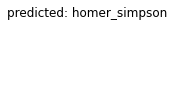

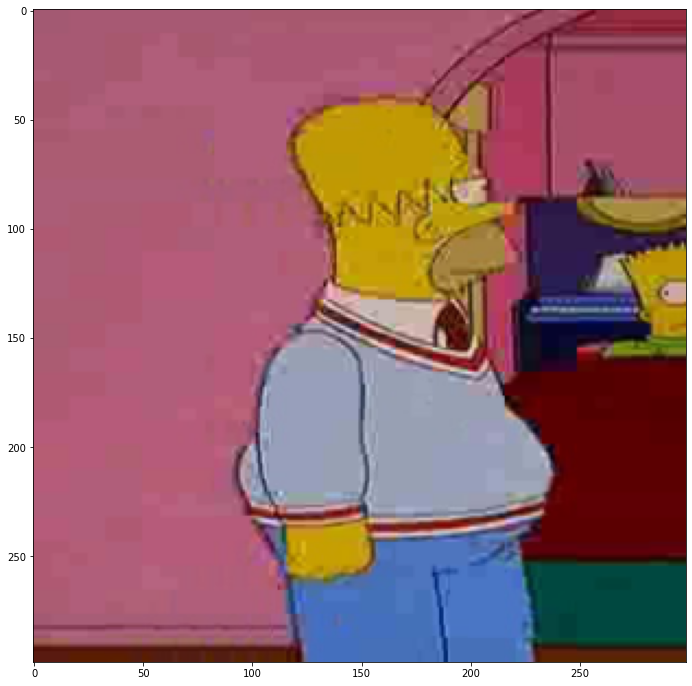

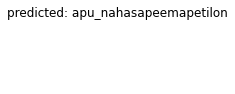

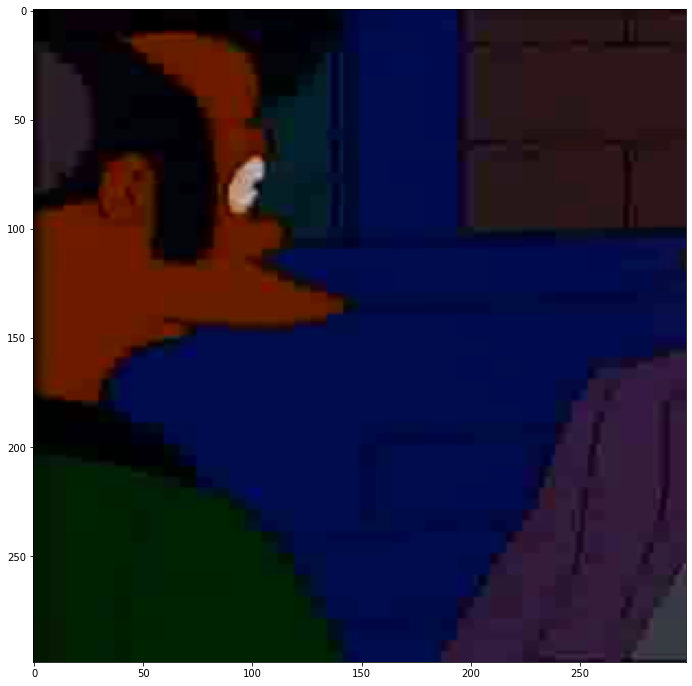

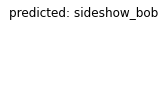

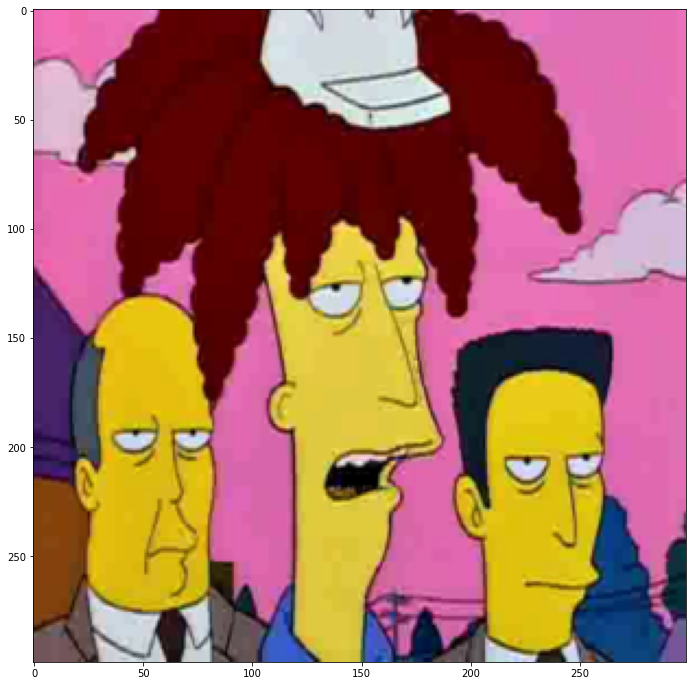

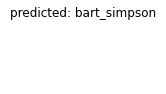

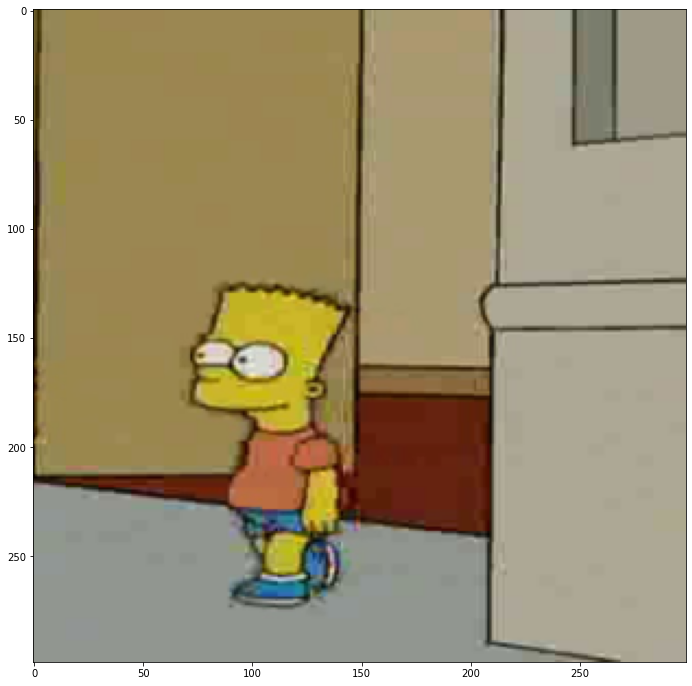

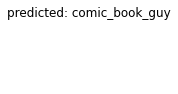

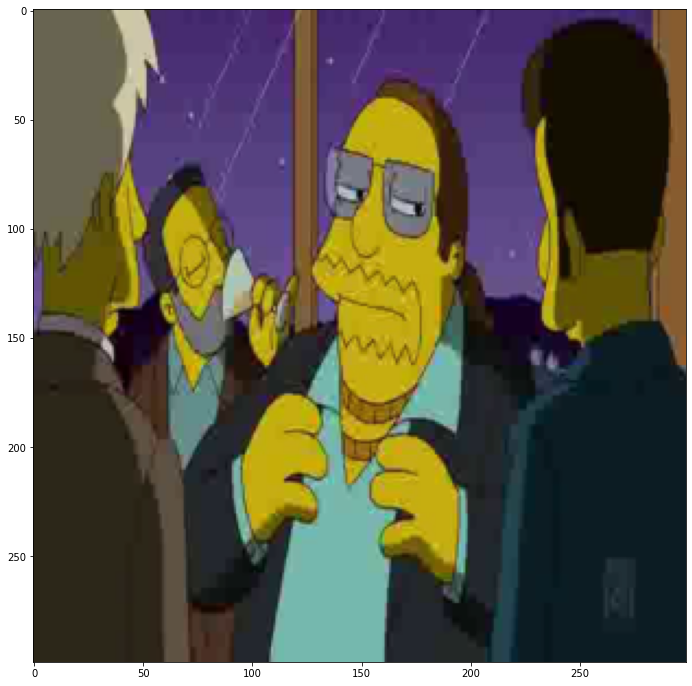

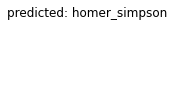

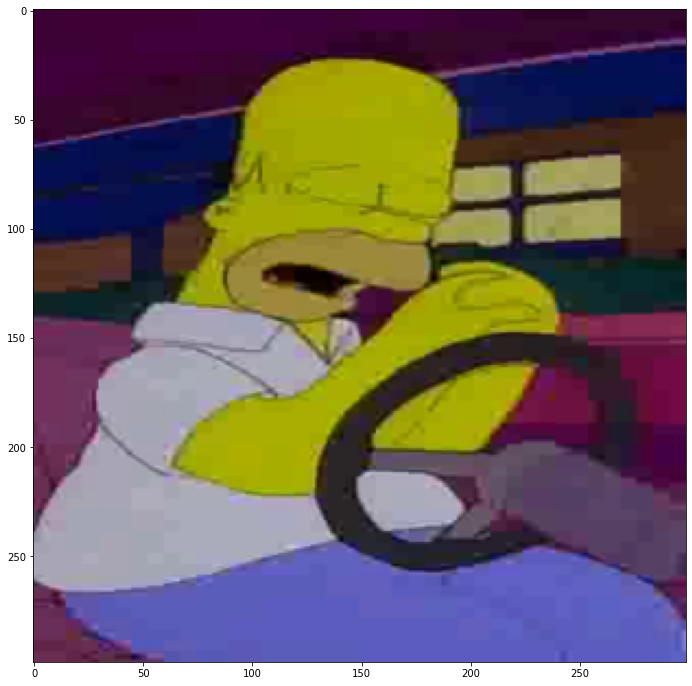

In [ ]:
visualize_model(i_model)

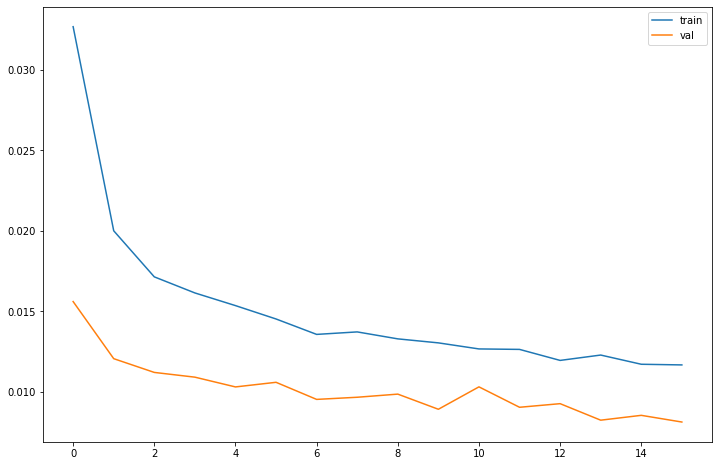

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
## make predictions on test
import pandas as pd
from PIL import Image
import helper
submissions = pd.DataFrame({'Id': [], 'Expected': []})
#i_model.to('cpu')
testdir = 'testset/testset'
test_files = sorted(list(Path(testdir).rglob('*.jpg')))
i_model.eval()
out = None
for f in test_files:
  image = Image.open(f)
  image.load()
  inp = data_transforms['test'](image).unsqueeze(0).cuda()
  out = i_model(inp)
  submissions = submissions.append({'Expected': class_names[torch.max(out.data, 1)[1].item()], 'Id': f.name}, ignore_index=True)
#out.shape

submissions.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
submissions.to_csv('gdrive/MyDrive/simpsons_contest.csv', index=False)